# Разработать модель для прогнозирования стоимости квартиры с учетом параметров квартиры и выполнения евроремонта.

## Описание

Задачи:
- Разработать модель машинного обучения для прогноза стоимости квартир `flats.xlsx`, если в них выполнят евроремонт на основании данных квартир с евроремонтом `euro_renovation.xlsx`
- Валидация модели и оценка точности на тестовой выборке
- Подготовка итогового отчета в Jupyter Notebook (Оценка)
- Добавить данные по стоимости квартиры с евроремонтом в `flats.xlsx` в отдельный столбец

Оценка:
- Обоснование выбора и применение ML алгоритмов
- Показать метрики качества модели и их анализ (например MSE, MAE, R2)
- Среда разработки  Jupyter Notebook

## Подготовка данных

### Загрузка модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime
import time
import geopy.distance 
# Модули, отсутствующие на платформе
import optuna

import shap


# Подбор
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)


print('Модули успешно загружены')

Модули успешно загружены


### Настройки

In [2]:
RANDOM_STATE = 281223
state = np.random.RandomState(RANDOM_STATE)
# Цветовая палитра документа
cm = 'crest'
mec = 'gray'
alpha = 0.7
fontsize = 14
figsize_base = 5
theme = 'darkgrid'
sns.set_style(theme)

def new_color(x='r'):
    '''Цвет графиков, по умолчанию случайный из заданной цветовой палитры. Принимает в качестве аргумента число, \
    соответствующее цвету в палитре.'''
    if x == 'r':
        return list(sns.color_palette(cm, 20)[random.randint(0,19)])
    return list(sns.color_palette(cm, 20)[x])
# Размеры

def figsize(width = 1, height=1):
    '''Задание размеров окна отрисовки.'''
    return (width*figsize_base, height*figsize_base)

# Отрисовка 
def plot_set(ax,title='',xlabel='',ylabel='',fontsize=fontsize,xrot=1,figsize=figsize()):
    '''Функция для отрисовки дополнительных параметров графиков. Подписьи осей и названия, размер шрифта и размер окна, 
    включение сетки.'''
    plt.xticks(rotation=45*(xrot), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title+'\n', fontsize=fontsize)
    plt.xlabel('\n'+xlabel, fontsize=fontsize)
    plt.ylabel(ylabel+'\n', fontsize=fontsize)
    plt.grid(visible=True, which='both')
    None
    
def mean_percent(x):
    '''Функция для форматирования значений. Округление до сотых и знак процента.'''
    try:
        return "{0:.2%}".format(x)
    except:
        return x

def describs(df):
    '''Функция для описания датафрейма'''
    print('Рассмотрим таблицу:\n')
    display(df.head(10))
    print('\nИнформация:\n')
    display(df.info())
    print('\nОписание:\n')
    display(df.describe())
    print('\nПропуски:\n')
    display(df.isna().mean().sort_values().apply(mean_percent))
    print('\nДубликаты:\n')
    display(df.duplicated().sum())

## Загрузка данных

In [3]:
flats = pd.read_excel('flats.xlsx').drop(0,axis=0)

In [4]:
euro_renovation = pd.read_excel('euro_renovation.xlsx').drop(0,axis=0)

In [5]:
describs(flats)

Рассмотрим таблицу:



,**id:** Идентификатор объекта.,**offer_views:** Количество просмотров объявления.,"**city:** Город, в котором расположен объект.",**lat:** Широта местоположения объекта.,**lon:** Долгота местоположения объекта.,**price_sq:** Цена за квадратный метр.,7**area:** Площадь объекта.,**floor:** Этаж объекта.,**kitchen_area:** Площадь кухни.,**bathroom_type:** Тип ванны.,**balconies:** Количество балконов.,**renovation:** Тип ремонта.,**is_apartment:** Является ли объект квартирой.,**rooms:** Количество комнат.,**has_gas:** Наличие газа.,**house_floors:** Количество этажей в доме.,**house_wall_type:** Тип стен дома.,**lifts:** Количество лифтов.,**freight_lifts:** Количество грузовых лифтов.,**time_on_foot_to_subway:** Время пешком до метро.,**build_year:** Год постройки объекта.,**urgent:** Срочное ли объявление.,**duplicates_count:** Количество дубликатов объявления.,**sale_type:** Тип продажи.,**all_data.house.ceiling_height:** Высота потолков в доме.,**all_data.house.has_garbage_disposer:** Наличие мусоропровода в доме.,**all_data.object_info.living_area:** Жилая площадь объекта.,**all_data.object_info.loggias:** Количество лоджий.,**all_data.house.parking[].display_name:** Опции парковки дома.,**all_data.house.yard[].display_name:** Опции двора дома.,**all_data.house.yard[].display_name:** Опции двора дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома.,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..2,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..3,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..4,**all_data.object_info.garage_type.display_name:** Тип гаража объекта.
1,1914739808,0,Казань,55.752364,49.171021,176510,49,18,12.5,NaN,0,NaN,NaN,1,NaN,23,Монолитный,1,0,24,2022,False,0,Свободная продажа,2.8,false,20.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1915485255,0,Москва,55.734623,37.613548,179404,38.6,5,0,NaN,0,NaN,NaN,1,True,6,Кирпичный,0,0,5,1900,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1914105595,0,Новосибирск,55.059296,82.974436,91863,38.1,1,12.1,Совмещенный,0,Косметический,False,1,False,5,Кирпичный,0,0,NaN,1950,False,0,Свободная продажа,NaN,false,14.5,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Парк,Фитнес,NaN
4,1914234894,0,Новосибирск,55.06373,82.934848,112903,31,4,6,Совмещенный,0,Косметический,False,1,False,5,Кирпичный,0,0,25,1964,False,0,Свободная продажа,2.8,false,18,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Парк,Детский сад,Фитнес,Торговый центр,NaN
5,1913219306,0,Казань,55.75363,49.24603,167682,65.6,2,13.8,NaN,1,NaN,False,2,True,10,Кирпичный,1,0,NaN,2013,False,0,NaN,NaN,NaN,NaN,NaN,NaN,Детская площадка,Спортивная площадка,NaN,NaN,NaN,NaN,NaN,NaN
6,1874814030,0,Казань,55.782522,49.184981,193159,44,8,13,NaN,0,NaN,NaN,1,NaN,20,Монолитный,1,0,NaN,NaN,False,0,NaN,NaN,NaN,14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1832787517,170,Москва,55.736356,37.694881,276000,25,3,5,NaN,0,Отсутствует,True,1,NaN,8,Кирпичный,1,1,8,2021,False,0,Свободная продажа,NaN,NaN,17,0,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Наземная парковка
8,1893766694,0,Новосибирск,55.101298,82.9699,120000,27.5,4,5.8,NaN,1,NaN,NaN,1,True,5,Кирпичный,0,0,NaN,1967,False,0,Свободная продажа,NaN,NaN,15.8,NaN,NaN,Детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1912844077,0,Новосибирск,55.079174,82.965902,105769,31.2,4,6,NaN,1,NaN,False,1,True,5,Кирпичный,0,0,NaN,1963,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1911841556,0,Новосибирск,55.012238,83.001242,86153,39,1,2.7,Совмещенный,1,Косметический,False,1,NaN,10,Панельный,0,0,57,NaN,False,0,Свободная продажа,NaN,NaN,25,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Парк,Детский сад,Фитнес,Торговый центр,NaN



Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 1 to 6691
Data columns (total 37 columns):
 #   Column                                                                     Non-Null Count  Dtype 
---  ------                                                                     --------------  ----- 
 0   **id:** Идентификатор объекта.                                             6691 non-null   object
 1   **offer_views:** Количество просмотров объявления.                         6691 non-null   object
 2   **city:** Город, в котором расположен объект.                              6691 non-null   object
 3   **lat:** Широта местоположения объекта.                                    6691 non-null   object
 4   **lon:** Долгота местоположения объекта.                                   6691 non-null   object
 5   **price_sq:** Цена за квадратный метр.                                     6690 non-null   object
 6   7**area:** Площадь объекта.                       

None


Описание:



,**id:** Идентификатор объекта.,**offer_views:** Количество просмотров объявления.,"**city:** Город, в котором расположен объект.",**lat:** Широта местоположения объекта.,**lon:** Долгота местоположения объекта.,**price_sq:** Цена за квадратный метр.,7**area:** Площадь объекта.,**floor:** Этаж объекта.,**kitchen_area:** Площадь кухни.,**bathroom_type:** Тип ванны.,**balconies:** Количество балконов.,**renovation:** Тип ремонта.,**is_apartment:** Является ли объект квартирой.,**rooms:** Количество комнат.,**has_gas:** Наличие газа.,**house_floors:** Количество этажей в доме.,**house_wall_type:** Тип стен дома.,**lifts:** Количество лифтов.,**freight_lifts:** Количество грузовых лифтов.,**time_on_foot_to_subway:** Время пешком до метро.,**build_year:** Год постройки объекта.,**urgent:** Срочное ли объявление.,**duplicates_count:** Количество дубликатов объявления.,**sale_type:** Тип продажи.,**all_data.house.ceiling_height:** Высота потолков в доме.,**all_data.house.has_garbage_disposer:** Наличие мусоропровода в доме.,**all_data.object_info.living_area:** Жилая площадь объекта.,**all_data.object_info.loggias:** Количество лоджий.,**all_data.house.parking[].display_name:** Опции парковки дома.,**all_data.house.yard[].display_name:** Опции двора дома.,**all_data.house.yard[].display_name:** Опции двора дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома.,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..2,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..3,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..4,**all_data.object_info.garage_type.display_name:** Тип гаража объекта.
count,6691,6691,6691,6691.000000,6691.0000,6690,6690,6690,6691,1482,6691,3599,5337,6690,4308,6691,6475,6691,6691,3707,5802,6691,6691,4984,2003.0,3379,4335,968,1591,2827,1556,1290,1251,1097,898,682,247
unique,6691,1088,7,3759.000000,3767.0000,5330,1074,29,425,3,4,32,2,6,2,35,10,5,3,88,136,2,6,5,71.0,2,667,4,7,2,2,5,5,5,5,5,3
top,1914739808,0,Казань,60.030245,30.2026,200000,32,1,0,Совмещенный,0,Косметический,False,1,True,9,Кирпичный,0,0,16,2023,False,0,Свободная продажа,2.7,true,18,1,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Фитнес,Торговый центр,Наземная парковка
freq,1,3710,2923,66.000000,75.0000,37,123,1213,1140,1071,3897,1186,4519,3316,2888,1480,2450,3652,5991,275,357,6610,6486,4123,383.0,2153,268,730,1172,2757,1524,1108,674,465,378,345,187



Пропуски:



**id:** Идентификатор объекта.                                                0.00%
**duplicates_count:** Количество дубликатов объявления.                       0.00%
**urgent:** Срочное ли объявление.                                            0.00%
**lifts:** Количество лифтов.                                                 0.00%
**house_floors:** Количество этажей в доме.                                   0.00%
**balconies:** Количество балконов.                                           0.00%
 **kitchen_area:** Площадь кухни.                                             0.00%
**freight_lifts:** Количество грузовых лифтов.                                0.00%
**offer_views:** Количество просмотров объявления.                            0.00%
**city:** Город, в котором расположен объект.                                 0.00%
**lat:** Широта местоположения объекта.                                       0.00%
**lon:** Долгота местоположения объекта.                                    


Дубликаты:



0

Рассмотрен датафрейм `flats.xlsx`:
- 37 столбцов
- 6691 строка
- Пропусков очень много, необходимо обработать
- Необходимо изменить названия столбцов
- Дубликатов нет

In [6]:
describs(euro_renovation)

Рассмотрим таблицу:



,**id:** Идентификатор объекта.,**offer_views:** Количество просмотров объявления.,"**city:** Город, в котором расположен объект.",**lat:** Широта местоположения объекта.,**lon:** Долгота местоположения объекта.,**price_sq:** Цена за квадратный метр.,**area:** Площадь объекта.,**floor:** Этаж объекта.,**kitchen_area:** Площадь кухни.,**bathroom_type:** Тип ванны.,**balconies:** Количество балконов.,**renovation:** Тип ремонта.,**is_apartment:** Является ли объект квартирой.,**rooms:** Количество комнат.,**has_gas:** Наличие газа.,**house_floors:** Количество этажей в доме.,**house_wall_type:** Тип стен дома.,**lifts:** Количество лифтов.,**freight_lifts:** Количество грузовых лифтов.,**time_on_foot_to_subway:** Время пешком до метро.,**build_year:** Год постройки объекта.,**urgent:** Срочное ли объявление.,**duplicates_count:** Количество дубликатов объявления.,**sale_type:** Тип продажи.,**all_data.house.ceiling_height:** Высота потолков в доме.,**all_data.house.has_garbage_disposer:** Наличие мусоропровода в доме.,**all_data.object_info.living_area:** Жилая площадь объекта.,**all_data.object_info.loggias:** Количество лоджий.,**all_data.house.parking[].display_name:** Опции парковки дома.,**all_data.house.yard[].display_name:** Опции двора дома.,**all_data.house.yard[].display_name:** Опции двора дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома.,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..2,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..3,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..4,**all_data.object_info.garage_type.display_name:** Тип гаража объекта.
1,1900703057,0,Москва,55.81212,37.632269,456666,15,1,3,NaN,0,Евро,True,0,NaN,4,NaN,0,0,10,NaN,False,0,Свободная продажа,NaN,false,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1871863655,0,Казань,55.728718,49.171865,199975,41.5,16,8.6,Совмещенный,1,Евро,False,1,False,19,Монолитный,1,1,NaN,2017,False,0,Свободная продажа,2.7,false,NaN,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Парк,Детский сад,Фитнес,Торговый центр,NaN
3,1912069065,0,Новосибирск,54.955856,82.838521,80263,38,1,9,NaN,0,Евро,False,1,NaN,10,Панельный,1,0,NaN,2012,False,0,Свободная продажа,NaN,true,19,1,NaN,Детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1915932774,0,Новосибирск,54.9309,82.91318,101754,28.5,7,0,Совмещенный,1,Евро,False,0,False,10,Панельный,1,0,NaN,2008,False,0,Альтернатива,2.7,true,21,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Парк,NaN,NaN
5,1902155995,0,Новосибирск,54.935571,82.885261,112500,20,5,0,Совмещенный,1,Евро,False,0,False,17,Панельный,2,0,NaN,2014,False,0,Свободная продажа,2.6,true,NaN,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Фитнес,NaN,NaN
6,1724816414,1739,Новосибирск,54.98836,82.868112,123333,15,2,2,Совмещенный,0,Евро,False,0,False,5,Кирпичный,1,0,26,1963,False,0,Свободная продажа,NaN,false,12,NaN,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Парк,Фитнес,NaN
7,1901669020,0,Новосибирск,55.092602,82.940273,78947,19,1,3.5,NaN,0,Евро,True,0,NaN,4,Кирпичный,0,0,NaN,1989,False,0,Свободная продажа,3,NaN,15.5,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Наземная парковка
8,1900717836,0,Новосибирск,55.092602,82.940273,85714,17.5,4,4,NaN,0,Евро,True,0,NaN,4,Кирпичный,0,0,NaN,1989,False,0,Свободная продажа,3,NaN,13.5,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Наземная парковка
9,1899737668,0,Новосибирск,54.934686,83.117017,92857,21,4,4,NaN,0,евроремонт,NaN,0,NaN,17,Панельный,1,1,NaN,2014,False,0,Свободная продажа,NaN,true,NaN,1,NaN,Детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1842839270,184,Новосибирск,54.938327,83.109229,90909,22,6,2,NaN,0,Евро,NaN,0,NaN,17,Монолитный,1,0,NaN,2011,False,0,NaN,NaN,true,15,1,NaN,Детская площадка,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 1 to 1320
Data columns (total 37 columns):
 #   Column                                                                     Non-Null Count  Dtype 
---  ------                                                                     --------------  ----- 
 0   **id:** Идентификатор объекта.                                             1320 non-null   object
 1   **offer_views:** Количество просмотров объявления.                         1320 non-null   object
 2   **city:** Город, в котором расположен объект.                              1320 non-null   object
 3   **lat:** Широта местоположения объекта.                                    1320 non-null   object
 4   **lon:** Долгота местоположения объекта.                                   1320 non-null   object
 5   **price_sq:** Цена за квадратный метр.                                     1320 non-null   object
 6   **area:** Площадь объекта.                        

None


Описание:



,**id:** Идентификатор объекта.,**offer_views:** Количество просмотров объявления.,"**city:** Город, в котором расположен объект.",**lat:** Широта местоположения объекта.,**lon:** Долгота местоположения объекта.,**price_sq:** Цена за квадратный метр.,**area:** Площадь объекта.,**floor:** Этаж объекта.,**kitchen_area:** Площадь кухни.,**bathroom_type:** Тип ванны.,**balconies:** Количество балконов.,**renovation:** Тип ремонта.,**is_apartment:** Является ли объект квартирой.,**rooms:** Количество комнат.,**has_gas:** Наличие газа.,**house_floors:** Количество этажей в доме.,**house_wall_type:** Тип стен дома.,**lifts:** Количество лифтов.,**freight_lifts:** Количество грузовых лифтов.,**time_on_foot_to_subway:** Время пешком до метро.,**build_year:** Год постройки объекта.,**urgent:** Срочное ли объявление.,**duplicates_count:** Количество дубликатов объявления.,**sale_type:** Тип продажи.,**all_data.house.ceiling_height:** Высота потолков в доме.,**all_data.house.has_garbage_disposer:** Наличие мусоропровода в доме.,**all_data.object_info.living_area:** Жилая площадь объекта.,**all_data.object_info.loggias:** Количество лоджий.,**all_data.house.parking[].display_name:** Опции парковки дома.,**all_data.house.yard[].display_name:** Опции двора дома.,**all_data.house.yard[].display_name:** Опции двора дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома.,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..1,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..2,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..3,**all_data.house.infrastructure[].display_name:** Инфраструктура дома..4,**all_data.object_info.garage_type.display_name:** Тип гаража объекта.
count,1320,1320,1320,1320.000000,1320.000000,1320,1320,1320,1320,553,1320,1320,1001,1320,918,1320,1270,1320,1320,736,1231,1320,1320,1297,669.0,766,1082,281,587,669,474,453,439,398,337,237,102
unique,1320,431,5,915.000000,914.000000,1169,511,25,170,3,3,5,2,5,2,31,9,4,3,43,106,2,4,4,53.0,2,295,3,6,2,2,5,5,5,5,5,3
top,1900703057,0,Казань,59.901594,30.219659,200000,20,1,0,Совмещенный,0,Евро,False,0,True,9,Кирпичный,1,0,12,2022,False,0,Свободная продажа,2.7,false,15,1,Во дворе,Детская площадка,Спортивная площадка,Школа,Детский сад,Торговый центр,Фитнес,Торговый центр,Наземная парковка
freq,1,737,472,22.000000,22.000000,11,26,221,311,466,816,1104,686,562,463,232,555,650,1068,63,97,1300,1271,1170,152.0,406,58,195,384,648,461,383,229,166,147,115,80



Пропуски:



**id:** Идентификатор объекта.                                                0.00%
 **duplicates_count:** Количество дубликатов объявления.                      0.00%
 **urgent:** Срочное ли объявление.                                           0.00%
 **lifts:** Количество лифтов.                                                0.00%
 **house_floors:** Количество этажей в доме.                                  0.00%
 **rooms:** Количество комнат.                                                0.00%
 **renovation:** Тип ремонта.                                                 0.00%
 **balconies:** Количество балконов.                                          0.00%
 **freight_lifts:** Количество грузовых лифтов.                               0.00%
**offer_views:** Количество просмотров объявления.                            0.00%
**floor:** Этаж объекта.                                                      0.00%
**area:** Площадь объекта.                                                  


Дубликаты:



0

Рассмотрен датафрейм `euro_renovation.xlsx`:
- 37 столбцов
- 1320 строк
- Пропусков очень много, необходимо обработать
- Необходимо изменить названия столбцов
- Дубликатов нет

## Предобработка данных

### Изменение наименований столбцов

Выделим названия столбцов.

In [7]:
flats.columns

Index(['**id:** Идентификатор объекта.',
       '**offer_views:** Количество просмотров объявления.',
       '**city:** Город, в котором расположен объект.',
       '**lat:** Широта местоположения объекта.',
       '**lon:** Долгота местоположения объекта.',
       '**price_sq:** Цена за квадратный метр.', '7**area:** Площадь объекта.',
       ' **floor:** Этаж объекта.', ' **kitchen_area:** Площадь кухни.',
       '**bathroom_type:** Тип ванны.', '**balconies:** Количество балконов.',
       '**renovation:** Тип ремонта.',
       '**is_apartment:** Является ли объект квартирой.',
       '**rooms:** Количество комнат.', '**has_gas:** Наличие газа.',
       '**house_floors:** Количество этажей в доме.',
       '**house_wall_type:** Тип стен дома.', '**lifts:** Количество лифтов.',
       '**freight_lifts:** Количество грузовых лифтов.',
       '**time_on_foot_to_subway:** Время пешком до метро.',
       '**build_year:** Год постройки объекта.',
       '**urgent:** Срочное ли объявление.

Изменим названия столбцов согласно следующим правилам:

- Использовать соглашение snake_case: Названия столбцов должны состоять из строчных букв, слова разделяются символом подчеркивания _.
- Описательные имена: Имена столбцов должны ясно отражать содержание информации, которую они хранят.

In [8]:
cols_new_name = ['id', 'offer_views', 'city', 'lat', 'lon', 'price_sq','area',
       'floor', 'kitchen_area', 'bathroom_type', 'balconies', 'renovation', 'is_apartment',
       'rooms', 'has_gas', 'house_floors', 'house_wall_type', 'lifts',
       'freight_lifts', 'time_on_foot_to_subway', 'build_year',
       'urgent', 'duplicates_count','sale_type', 'height',
       'garbage_disposer', 'living_area', 'loggias', 'parking',
       'yard_1', 'yard_2', 'infrastructure_0', 'infrastructure_1',
       'infrastructure_2', 'infrastructure_3', 'infrastructure_4', 'garage']

In [9]:
flats.columns = cols_new_name
euro_renovation.columns = cols_new_name

### Изменение типов данных

Выделим разные типы столбцов: числовые, категориальные, булевы.

In [10]:
cols_numeric = ['price_sq','area',
       'floor', 'kitchen_area', 'balconies', 
       'rooms', 'house_floors', 'lifts',
       'freight_lifts', 'time_on_foot_to_subway', 'build_year',
       'duplicates_count','height',
       'living_area', 'loggias']
cols_bool = ['is_apartment', 'has_gas', 'urgent', 'garbage_disposer']
cols_categorial = ['city', 'bathroom_type','renovation', 'house_wall_type', 'sale_type', 'parking',
       'yard_1', 'yard_2', 'infrastructure_0', 'infrastructure_1',
       'infrastructure_2', 'infrastructure_3', 'infrastructure_4', 'garage']

Изменим типы данных у числовых столбцов.

In [11]:
flats[cols_numeric] = flats[cols_numeric].astype('float')
euro_renovation[cols_numeric] = euro_renovation[cols_numeric].astype('float')

Изменим типы данных у булевых столбцов.

In [12]:
def conver_func(df):
    df_new = df.copy()
    df_new['is_apartment'] = (df_new['is_apartment'] == 'True').astype('int')
    df_new['has_gas'] = (df_new['has_gas'] == 'True').astype('int')
    df_new['urgent'] = (df_new['urgent'] == 'True').astype('int')
    df_new['garbage_disposer'] = (df_new['garbage_disposer'] == 'true').astype('int')
    
    return df_new

In [13]:
euro_renovation = conver_func(euro_renovation)
flats = conver_func(flats)

### Распределения

Рассмотрим распределения данных в числовых столбцах:

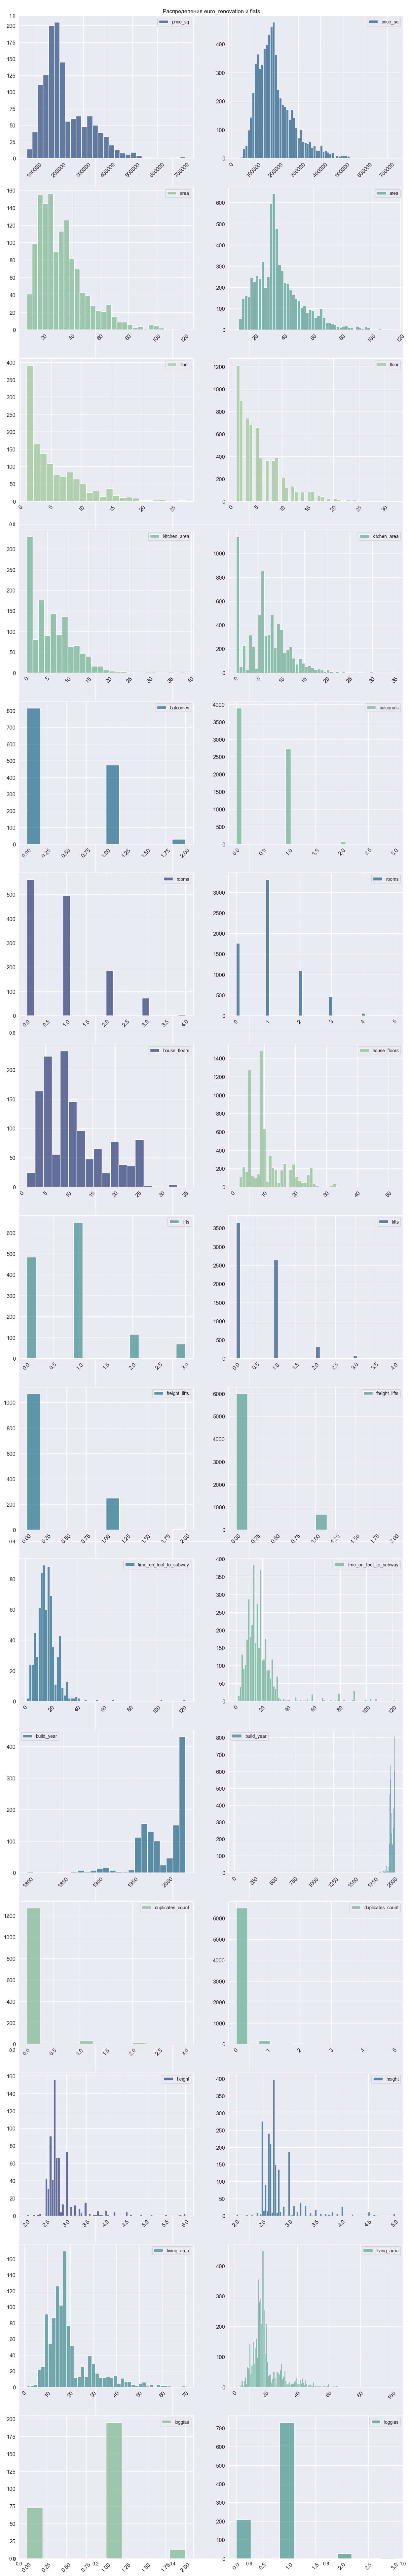

In [14]:
plt.figure(figsize=figsize(3,20))
plt.title(' Распределения euro_renovation и flats')
for c in range(len(cols_numeric)):
    plt.subplot(15,2,2*c+1)
    ax = sns.histplot(euro_renovation[cols_numeric[c]],color=new_color(),alpha=alpha)
    plt.legend([cols_numeric[c]])
    plot_set(ax,xrot=1, fontsize=12)

    plt.subplot(15,2,2*c+2)
    ax = sns.histplot(flats[cols_numeric[c]],color=new_color(),alpha=alpha)
    plt.legend([cols_numeric[c]])
    plot_set(ax,xrot=1, fontsize=12)

Аномальные значения наблюдаются только в годах постройки flats

In [15]:
flats['build_year'].sort_values().head(5)

3289      23.0
6348    1776.0
6330    1798.0
6331    1806.0
6246    1820.0
Name: build_year, dtype: float64

Судя по всему просто ошибка. Исправим.

In [16]:
flats.loc[3289,'build_year']=2023

Построим матрицу корреляций.

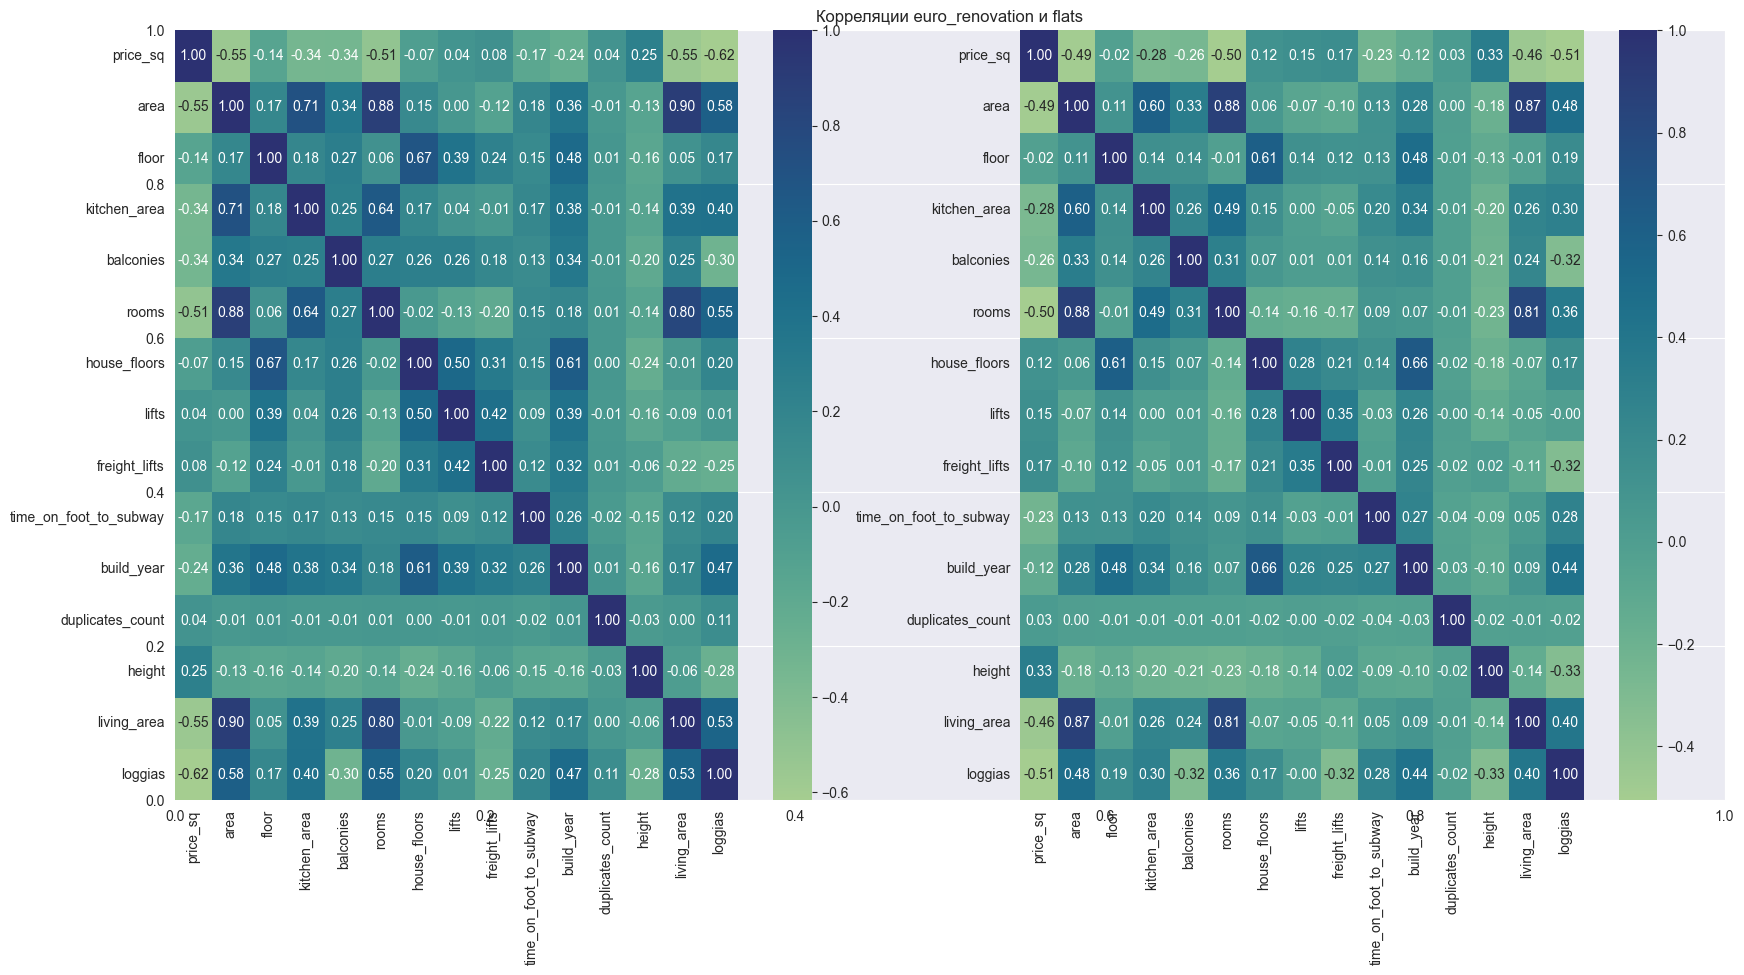

In [17]:
plt.figure(figsize=figsize(4,2))
plt.title('Корреляции euro_renovation и flats')
plt.subplot(1,2,1)
sns.heatmap(euro_renovation[cols_numeric].corr(), annot=True, cmap=cm, fmt='.2f')

plt.subplot(1,2,2)
sns.heatmap(flats[cols_numeric].corr(), annot=True, cmap=cm, fmt='.2f')
None

Необычных корреляций нет

Рассмотрим распределения данных в категориальных столбцах:

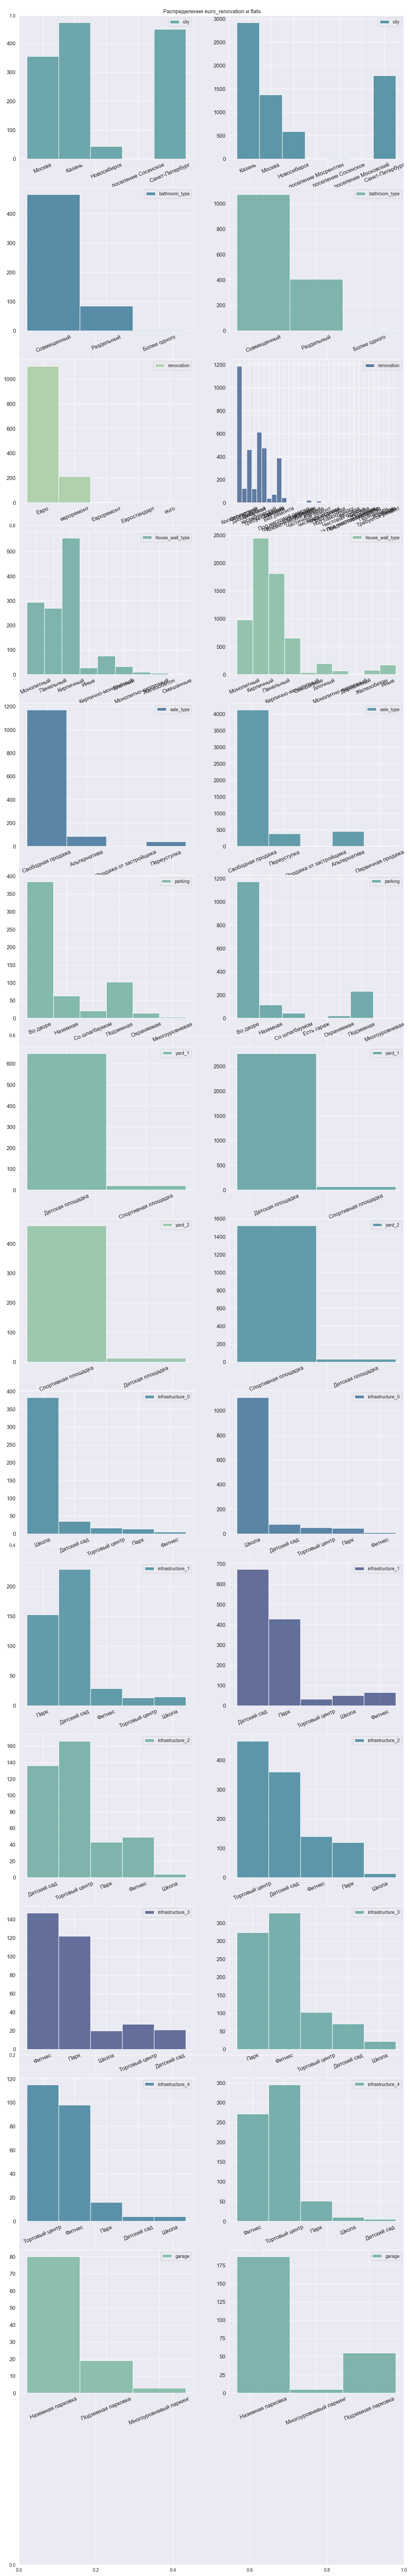

In [18]:
plt.figure(figsize=figsize(3,20))
plt.title(' Распределения euro_renovation и flats')
for c in range(len(cols_categorial)):
    plt.subplot(15,2,2*c+1)
    ax = sns.histplot(euro_renovation[cols_categorial[c]],color=new_color(),alpha=alpha)
    plt.legend([cols_categorial[c]])
    plot_set(ax,xrot=0.5, fontsize=12)

    plt.subplot(15,2,2*c+2)
    ax = sns.histplot(flats[cols_categorial[c]],color=new_color(),alpha=alpha)
    plt.legend([cols_categorial[c]])
    plot_set(ax,xrot=0.5, fontsize=12)

Распределение возможных значений в датафрейме flats больше чем в euro_renovation. Объясняется размерами выборки. Это может стать проблемой при обучении

Рассмотрим распределения данных в булевых столбцах:

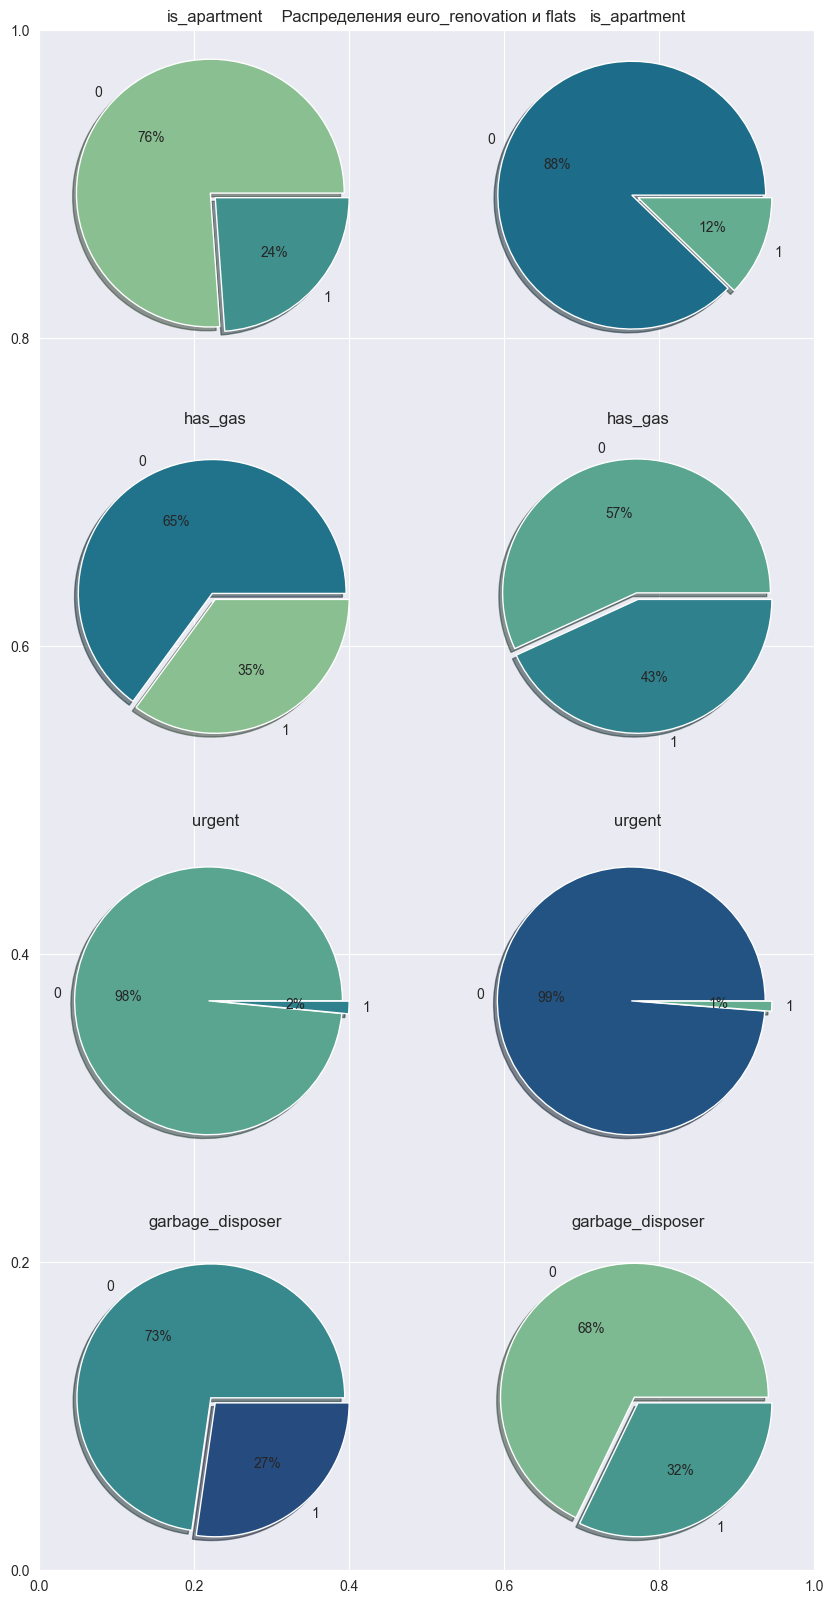

In [19]:
plt.figure(figsize=figsize(2,4))
plt.title(' Распределения euro_renovation и flats')
for c in range(len(cols_bool)):
    plt.subplot(4,2,2*c+1)
    euro_renovation[cols_bool[c]].value_counts().plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    title = cols_bool[c],
    colors=[new_color(),new_color()],explode = (0.05,0), shadow=True);
    plt.ylabel('')

    plt.subplot(4,2,2*c+2)
    flats[cols_bool[c]].value_counts().plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    title = cols_bool[c],
    colors=[new_color(),new_color()],explode = (0.05,0), shadow=True);
    plt.ylabel('')
None

Распределения в даиафреймах в целом схожи.

Выделим города, которые есть в списке для добавления новых признаков.

In [20]:
euro_renovation['city'].value_counts()

city
Казань                 472
Санкт-Петербург        449
Москва                 355
Новосибирск             43
поселение Сосенское      1
Name: count, dtype: int64

Создадим датафрейм с центрами городов из списка.

In [21]:
centers = pd.DataFrame({'Казань': [55.7910, 49.12068], 'Санкт-Петербург': [59.9386, 30.3141], 'Москва' : [55.753995, 37.614069], 'Новосибирск': [55.0415, 82.9346]}, index=['lat','lon']).T

Добавим их в основные датафреймы.

In [22]:
df_euro_renovation = euro_renovation.merge(centers,how='left',left_on='city',right_index=True)
df_flats = flats.merge(centers,how='left',left_on='city',right_index=True)

### Обработка пропусков

Зададим функцию для обработки пропусков.

Функция будет состоять из следующих частей:
- Удалим все строки с пропусками `price_sq`.
- Удалим столбцы `id`,`offer_views`,`renovation`, они не будут играть роль в обучении.
- Заменим все пропуски `is_apartment` на `False`, так как скорее всего, если это аппартаменты это было бы указано явно.
-  Заменим все пропуски `time_on_foot_to_subway` на `-1`, так как заполнить их достаточно сложно (но можно при необходимости выгрузить все станции метро и отобрать ближайшие)
- Заменим все пропуски `has_gas` на `False`, так как в новых домах (высотных) от газа отказываются
-  Заменим все пропуски `house_wall_type` на `Неизвестный материал`
    - Дополнительно заменим материал `Кирпично-монолитный` на `Монолитно-кирпичный`
-  Заменим все пропуски `bathroom_type` на Неизвестный тип ванны
-  Заменим все пропуски `height` на медианное значение высот потолков
-  Заполним пропуски в `build_yea`r методом ближайших соседей (вполне вероятно что находящиеся рядом дома были построены примерно в одно время):
    - выделим координаты домов, у которых указан год постройки
    - обучим модель  `KNNImputer` на этих данных
    - выделим координаты домов без года постройки
    - на основе обученной модели заполним пропуски
-  Заполним пропуски в `living_area` методом ближайших соседей (вполне вероятно что дома одной общей площади с близкой площадью кухонь и одинаковым числом комнат имеют близкую жилую площади):
    - выделим характеристики общая площадь, площадь кухни, число комнат , у которых указана жилая площадь
    - обучим модель  `KNNImputer` на этих данных
    - выделим характеристики без известной жилой площади
    - на основе обученной модели заполним пропуски
- Заменим все пропуски `sale_type` на Свободная продажа
- Заменим все пропуски `garbage_disposer` на `False`
- Заменим все пропуски `loggias` на `0`
- Заменим все пропуски `parking` на `Во дворе`
- Заменим все пропуски `garage` на `Нет`
- Вместо `yard_1` и `yard_2` введём новые столбцы child и sport со значениеми `1` в случае если рядом есть детская или спортивная площадка соответственно. Если их нет, значение `0`
- Вместо `infrastructure_0` -  `infrastructure_4` введём новые столбцы `school`, `garden`, `mall`, `fitnes`, `park` со значениеми `1` в случае если рядом есть школа, детский сад, ТЦ, фитнес или парк соответственно. Если их нет, значение `0`
- Для городов не из списка локаций (Казань, 
Санкт-Петербу, 
Моск, 5
Новосибир расстояние будем отсчитывать от центра Москвы.ск)

In [23]:
def fill_na_func(df):
    df_new = df.copy()
    df_new = df_new.dropna(axis=0,subset=['price_sq'])
    df_new = df_new.drop(['id','offer_views','renovation'],axis=1)
    df_new['is_apartment'] = df_new['is_apartment'].fillna('False')
    df_new['time_on_foot_to_subway'] = df_new['time_on_foot_to_subway'].fillna(-1)
    df_new['has_gas'] = df_new['has_gas'].fillna('False')
    df_new['house_wall_type'] = df_new['house_wall_type'].fillna('Неизвестный материал')
    df_new['bathroom_type'] = df_new['bathroom_type'].fillna('Неизвестный тип ванны')
    df_new['height'] = df_new['height'].fillna(df_new['height'].median())
    df_new.loc[df_new['house_wall_type']=='Кирпично-монолитный','house_wall_type'] = 'Монолитно-кирпичный'
    
    have_year = df_new[df_new['build_year'].notna()][['lat_x', 'lon_x','build_year']]
    have_not_year = df_new[df_new['build_year'].isna()][['lat_x', 'lon_x','build_year']]
    model_year = KNNImputer()
    model_year.fit(have_year)
    predict_year = model_year.transform(have_not_year)[:,2]
    df_new.loc[df_new['build_year'].isna(),'build_year'] = predict_year.round()
    
    have_living_area = df_new[df_new['living_area'].notna()][['area', 'kitchen_area', 'rooms','living_area']]
    have_not_living_area = df_new[df_new['living_area'].isna()][['area', 'kitchen_area', 'rooms','living_area']]
    model_area = KNNImputer()
    model_area.fit(have_living_area)
    predict_area = model_area.transform(have_not_living_area)[:,3]
    df_new.loc[df_new['living_area'].isna(),'living_area'] = predict_area.round(1)
    
    df_new['sale_type'] = df_new['sale_type'].fillna('Свободная продажа')
    df_new['garbage_disposer'] = df_new['garbage_disposer'].fillna('False')
    df_new['loggias'] = df_new['loggias'].fillna(0)
    df_new['parking'] = df_new['parking'].fillna('Во дворе')
    df_new['garage'] = df_new['garage'].fillna('Нет')

    
    df_new['child'] = 0
    df_new['sport'] = 0
    df_new['school'] = 0
    df_new['garden'] = 0
    df_new['mall'] = 0
    df_new['fitnes'] = 0
    df_new['park'] = 0

    for i in ['1','2']:
        df_new.loc[df_new['yard_'+i] == 'Детская площадка', 'child'] = 1
        df_new.loc[df_new['yard_'+i] == 'Спортивная площадка', 'sport'] = 1
        df_new = df_new.drop('yard_'+i,axis=1)

    for i in ['0', '1', '2', '3', '4']:
        df_new.loc[df_new['infrastructure_'+i] == 'Школа', 'school'] = 1
        df_new.loc[df_new['infrastructure_'+i] == 'Детский сад', 'garden'] = 1
        df_new.loc[df_new['infrastructure_'+i] == 'Торговый центр', 'mall'] = 1
        df_new.loc[df_new['infrastructure_'+i] == 'Фитнес', 'fitnes'] = 1
        df_new.loc[df_new['infrastructure_'+i] == 'Парк', 'park'] = 1
        df_new = df_new.drop('infrastructure_'+i,axis=1)

    df_new['lat_y'] = df_new['lat_y'].fillna(centers.loc['Москва','lat'])
    df_new['lon_y'] = df_new['lon_y'].fillna(centers.loc['Москва','lon'])
    
    return df_new

In [24]:
df_euro_renovation = fill_na_func(df_euro_renovation)
df_flats = fill_na_func(df_flats)

Все пропуски заполнены

На основе данных о локации установим удалённость дома от центра (используем модуль geopy)

In [25]:
df_euro_renovation['dist'] = df_euro_renovation.apply(lambda row: geopy.distance.geodesic([row['lat_x'],row['lon_x']], [row['lat_y'],row['lon_y']]).km, axis=1)
df_flats['dist'] = df_flats.apply(lambda row: geopy.distance.geodesic([row['lat_x'],row['lon_x']], [row['lat_y'],row['lon_y']]).km, axis=1)

Удалим данне о координатах. Сами по себе они имеют мало значения.

In [26]:
df_euro_renovation = df_euro_renovation.drop(['lat_x','lat_y','lon_x','lon_y'],axis=1)
df_flats = df_flats.drop(['lat_x','lat_y','lon_x','lon_y'],axis=1)

### Кодирование категориальных признаков

Так как данных не очень много, для перевода категориальных признаков в числовые воспользуемся методом onehotencoder, он внесёт меньше неоднозначности в данные. Неизвестные данные для кодирования проигнорируем, их мало и мы всё равно не сможем их корректно обработать.

In [27]:
col_ohe = ['city', 'bathroom_type', 'house_wall_type', 'sale_type', 'parking', 'garage']

In [28]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
onehotencoder = onehotencoder.fit(df_euro_renovation[col_ohe])

In [29]:
def ohe_trans(df):
    df_new = df.copy()
    data = onehotencoder.transform(df[col_ohe])
    df_new = df_new.drop(col_ohe,axis=1).merge(pd.DataFrame(data.toarray(),columns=np.concatenate(onehotencoder.categories_),index=df.index),how='inner',left_index=True,right_index=True)
    return df_new

In [30]:
df_flats = ohe_trans(df_flats)

In [31]:
df_euro_renovation = ohe_trans(df_euro_renovation)

## Обучение моделей

Выделим признаки для предсказания и целевой признак.

In [32]:
X = df_euro_renovation.drop('price_sq',axis=1)
Y = pd.DataFrame(df_euro_renovation['price_sq'])

Разделим выборку на обучающую и тестовую. Тестовая будет составлять 20%

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

Зададим функцию для подбора гипперпараметров моделей. В качестве моделей будут:  `RandomForestRegressor`, `XGBRegressor` и `CatBoostRegressor`. Для подбора гипперпараметров использован метод кросс-валидации с разделением выборки на 5 частей.

In [34]:
def objective(trial,features=X_train,target=Y_train):
    if model_type == 'random_forest':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_depth': trial.suggest_int('max_depth', 1, 60),
        }

        # создаем модель
        model = RandomForestRegressor(**param, random_state=RANDOM_STATE)
        
        
    elif model_type == 'xg_boost':
        param = {
            #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0,log=True),
            #'alpha': trial.suggest_float('alpha', 1e-3, 10.0,log=True),
            #'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            #'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        model = xgb.XGBRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'cat_boost':
        param = {
            #'loss_function': 'RMSE',
            'verbose' : False,
            #'task_type': 'GPU',
            #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0,log=True),
            #'max_bin': trial.suggest_int('max_bin', 200, 400),
            #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
            #'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.006, 0.018),
            'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
            #'max_depth': trial.suggest_int('max_depth', 5, 16),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        }
        model = CatBoostRegressor(**param, random_state=RANDOM_STATE)

    
    
    score = cross_val_score(model, features, target, cv = 5, scoring='r2', n_jobs = 2).mean()
    
    return -score

In [35]:
def search_best_params(model_type,n_trials):
    sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(study_name=model_type,
                                       direction="minimize",
                                       sampler=sampler)
    # ищем лучшую комбинацию гиперпараметров n_trials раз
    study.optimize(objective, n_trials=n_trials)

    
    return study.best_params, study.best_value, study

In [36]:
def model_visualization(model_type, n_trials=10):
    best_params, best_value, study = search_best_params(model_type=model_type,n_trials=n_trials)
    
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_type == 'xg_boost':
        model = xgb.XGBRegressor(**best_params, random_state=RANDOM_STATE)
    elif model_type == 'cat_boost':
        model = CatBoostRegressor(**best_params, random_state=RANDOM_STATE,verbose=False)
    
    model.fit(X_train,Y_train)
    
    shap_test = shap.TreeExplainer(model).shap_values(X_test)
    shap.summary_plot(shap_test, X_test,cmap=cm,plot_size=figsize(2))
        
    return best_params, best_value

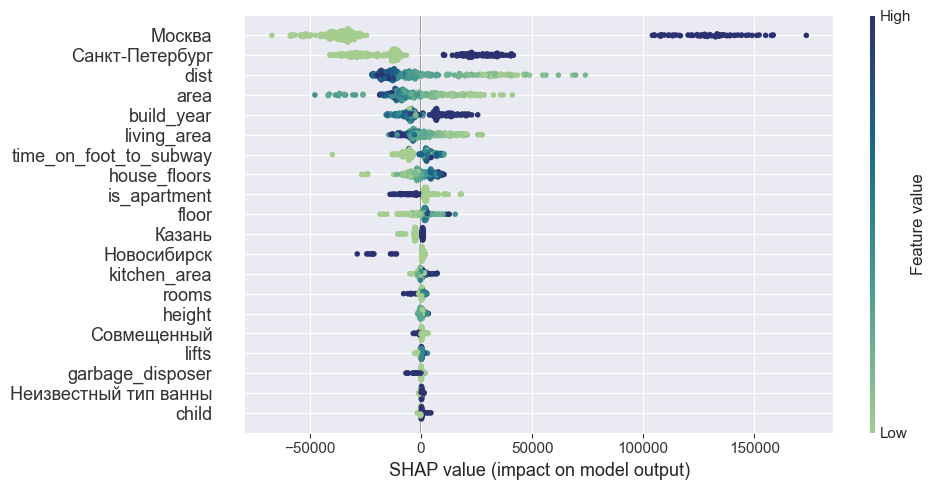

In [37]:
model_type = 'random_forest'
n_trials = 10
best_params_for, best_value_for = model_visualization(model_type,n_trials)

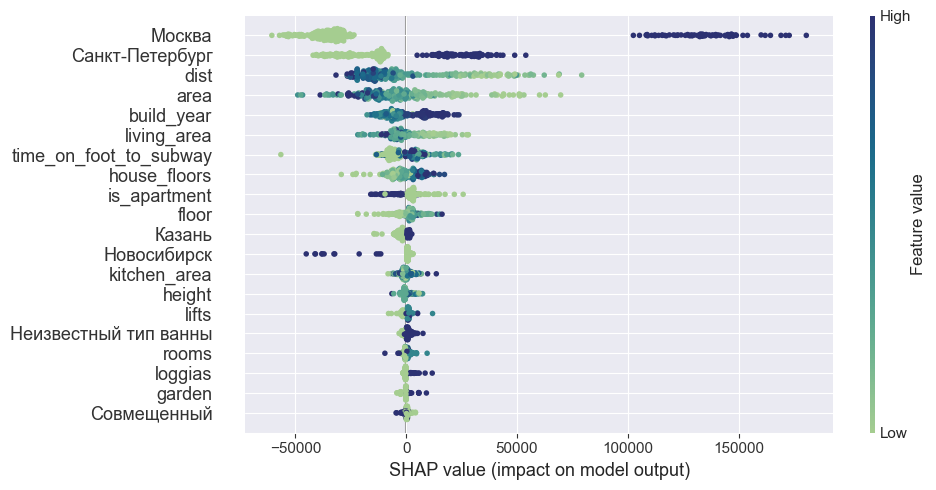

In [38]:
model_type = 'xg_boost'
n_trials = 100
best_params_xgb, best_value_xgb = model_visualization(model_type,n_trials)

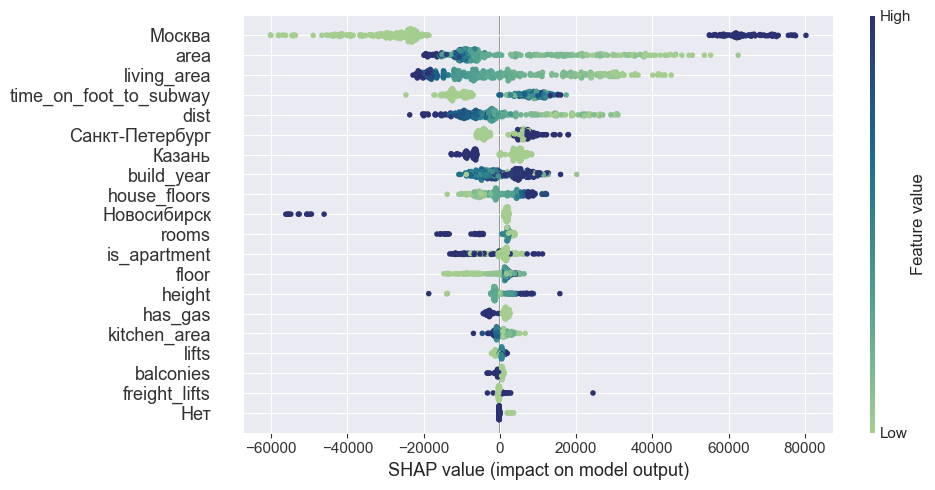

In [39]:
model_type = 'cat_boost'
n_trials = 10
best_params_cat, best_value_cat = model_visualization(model_type,n_trials)

- Наиболее важными признаками в формировании цены оказываются:
    - Город, в частности в Москве цены выше;
    - Общая и жилая площадь, чем выше площадь, тем ниже цена за квадрат;
    - Время до метро и удалённость от центра.

In [40]:
models = ['random_forest', 'xg_boost', 'cat_boost']
data_metrics = pd.DataFrame({'R2': [-best_value_for,-best_value_xgb,-best_value_cat]},index=models).T
data_metrics

,random_forest,xg_boost,cat_boost
R2,0.831258,0.834911,0.829353


### Проверка моделей на адекватность

In [41]:
dmb_model = DummyRegressor(strategy='median')

In [42]:
-cross_val_score(dmb_model, X_train, Y_train, cv = 5, scoring='r2', n_jobs = 2).mean()

0.08823606246518731

In [43]:
-cross_val_score(dmb_model, X_train, Y_train, cv = 5, scoring='neg_mean_absolute_error', n_jobs = 2).mean()

68759.64552445676

In [44]:
-cross_val_score(dmb_model, X_train, Y_train, cv = 5, scoring='neg_root_mean_squared_error', n_jobs = 2).mean()

95301.8129549467

Обученные модели показывают намного лучший результат, чем случайный. Модели проходят проверку на адекватность.

## Тестирование модели

Обучим лучшую модель

In [45]:
print(f'Лучшие параметры: {best_params_xgb}')

Лучшие параметры: {'lambda': 0.0020426773611167182, 'n_estimators': 170, 'max_depth': 7}


In [46]:
model = xgb.XGBRegressor(**best_params_xgb, random_state=RANDOM_STATE)

In [47]:
model = model.fit(X_train,Y_train)

### Тестовая выборка

Посмотрим на метрики:

In [48]:
Y_pred = pd.DataFrame(model.predict(X_test),index=X_test.index).rename(columns={0:'price_sq'})

In [49]:
print(f'R2: {r2_score(Y_pred,Y_test)}')

R2: 0.8414874842741593


In [50]:
print(f'MAE: {mean_absolute_error(Y_pred,Y_test)}')

MAE: 22792.58904474432


In [51]:
print(f'MRSE: {mean_squared_error(Y_pred,Y_test)**0.5}')

MRSE: 36378.36389796862


Сравним тестовые значения и предсказания

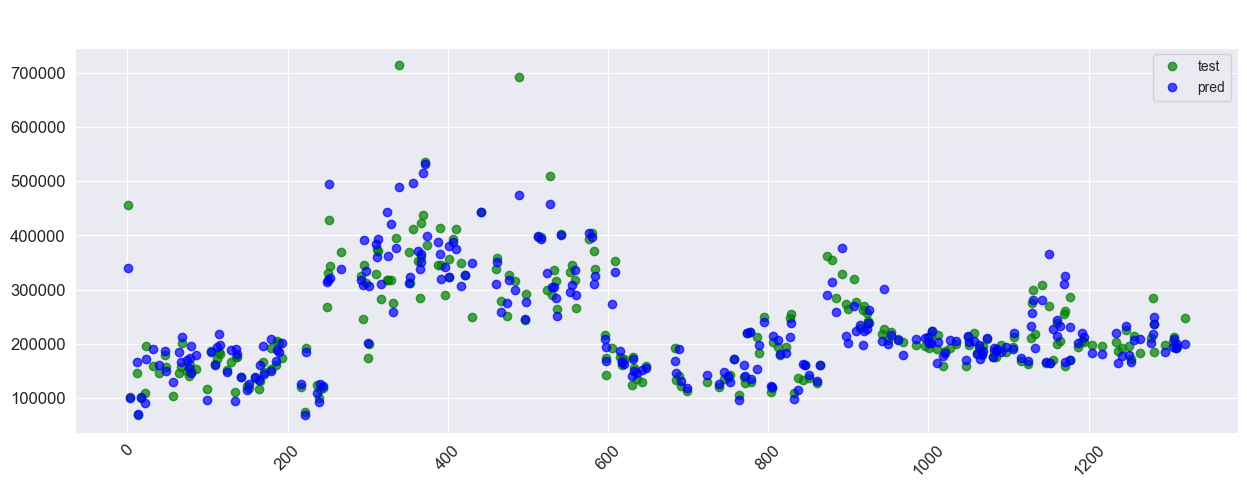

In [52]:
plt.figure(figsize=figsize(3))
plt.plot(Y_test.index, Y_test, 'go', Y_pred.index, Y_pred, 'bo',alpha=alpha)
plt.legend(['test','pred'])
plot_set(ax,xrot=1,fontsize=12)

Сложности со слишком высокими ценами

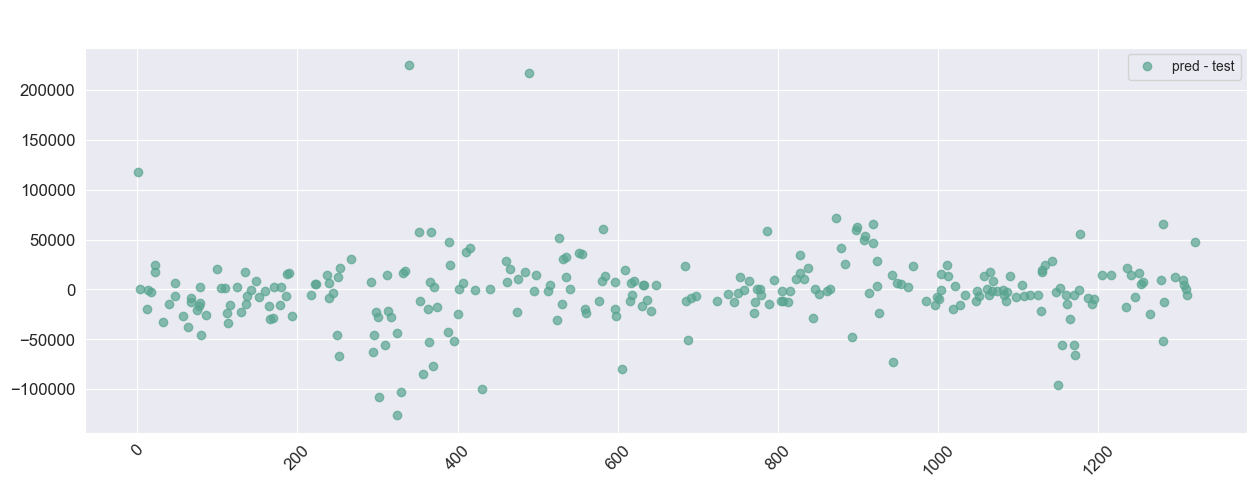

In [53]:
plt.figure(figsize=figsize(3))
plt.plot(Y_test.index, Y_test-Y_pred, 'o',alpha=alpha, color=new_color())
plt.legend(['pred - test'])
plot_set(ax,xrot=1,fontsize=12)

В целом разница вблизи 0

### Датафрейм flats

Предскажем значения цены для датафрейма flats. Дообучим модель на всех данных.

In [54]:
model = model.fit(X,Y)

In [55]:
Y_flats_pred = pd.DataFrame(model.predict(df_flats.drop('price_sq',axis=1)),index=df_flats.index).rename(columns={0:'price_sq'})

In [56]:
Y_flats_test = pd.DataFrame(df_flats['price_sq'])

Сравним с исходными ценами

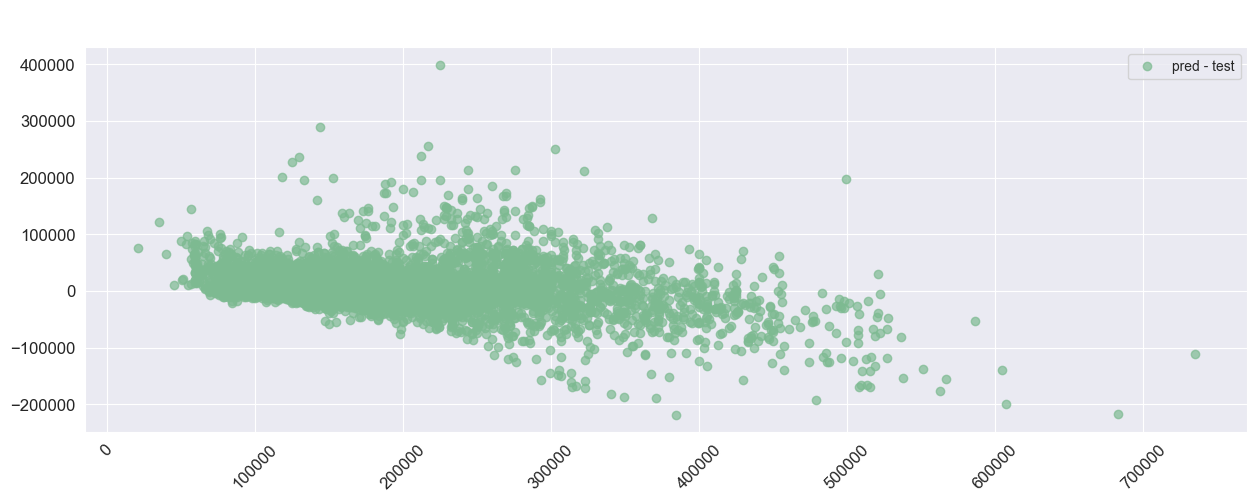

In [57]:
plt.figure(figsize=figsize(3))
ax = plt.plot(Y_flats_test,Y_flats_pred-Y_flats_test, 'o',alpha=alpha, color=new_color())
plt.legend(['pred - test'])
plot_set(ax,xrot=1,fontsize=12)

Видно, что для диапазона низких цен, предсказанная цена оказывается выше, то есть наличие ремонта повышает цену. Для высоких цен такой логики не видно, ремонт не играет роли в цене. Колебания в цене и широту распределения можно объяснить размерами выборок. Тестовая оказалось больше, чем обучающая.

Запишем новый столбец в исходный датафрейм.

In [58]:
flats = pd.read_excel('flats.xlsx').drop(0,axis=0)

In [59]:
flats_new = flats.merge(Y_flats_pred, how='left',right_index=True, left_index=True)

In [60]:
flats_new.to_excel('flats_new.xlsx',index=False)

## Вывод

- Загружены данные:
    - Рассмотрен датафрейм `flats.xlsx`:
        - 37 столбцов;
        - 6691 строка;
        - Дубликатов нет.
    - Рассмотрен датафрейм `euro_renovation.xlsx`:
        - 37 столбцов;
        - 1320 строк;
        - Дубликатов нет,
- Датафреймы обработаны:
    - Изменены названия столбцов согласно следующим правилам:
        - Использовать соглашение snake_case: Названия столбцов должны состоять из строчных букв, слова разделяются символом подчеркивания _.
        - Описательные имена: Имена столбцов должны ясно отражать содержание информации, которую они хранят.
    - Изменены типы данных н соответствующие содержанию.
    - Рассмотрены распределения данных:
        - Аномальные значения обработаны;
        - Распределения в даиафреймах в целом схожи.
    - Обработаны пропуски:
        - Удалены все строки с пропусками `price_sq`.
        - Удалены столбцы `id`,`offer_views`,`renovation`, они не будут играть роль в обучении.
        - Заменены все пропуски `is_apartment` на `False`, так как скорее всего, если это аппартаменты это было бы указано явно.
        - Заменены все пропуски `time_on_foot_to_subway` на `-1`, так как заполнить их достаточно сложно (но можно при необходимости выгрузить все станции метро и отобрать ближайшие)
        - Заменены все пропуски `has_gas` на `False`, так как в новых домах (высотных) от газа отказываются
        - Заменены все пропуски `house_wall_type` на `Неизвестный материал`
            - Дополнительно заменены материал `Кирпично-монолитный` на `Монолитно-кирпичный`
        -  Заменены все пропуски `bathroom_type` на `Неизвестный тип ванны`
        -  Заменены все пропуски `height` на медианное значение высот потолков
        -  Заполнены пропуски в `build_yea`r методом ближайших соседей (вполне вероятно что находящиеся рядом дома были построены примерно в одно время):
            - выделегы координаты домов, у которых указан год постройки
            - обучена модель  `KNNImputer` на этих данных
            - выделены координаты домов без года постройки
            - на основе обученной модели заполнены пропуски
        -  Заполнены пропуски в `living_area` методом ближайших соседей (вполне вероятно что дома одной общей площади с близкой площадью кухонь и одинаковым числом комнат имеют близкую жилую площади):
            - выделены характеристики общая площадь, площадь кухни, число комнат , у которых указана жилая площадь
            - обучена модель  `KNNImputer` на этих данных
            - выделена характеристики без известной жилой площади
            - на основе обученной модели заполнена пропуски
        - Заменены все пропуски `sale_type` на Свободная продажа
        - Заменены все пропуски `garbage_disposer` на `False`
        - Заменены все пропуски `loggias` на `0`
        - Заменены все пропуски `parking` на `Во дворе`
        - Заменены все пропуски `garage` на `Нет`
        - Вместо `yard_1` и `yard_2` введены новые столбцы `child` и `sport` со значениеми `1` в случае если рядом есть детская или спортивная площадка соответственно. Если их нет, значение `0`
        - Вместо `infrastructure_0` -  `infrastructure_4` введены новые столбцы `school`, `garden`, `mall`, `fitnes`, `park` со значениеми `1` в случае если рядом есть школа, детский сад, ТЦ, фитнес или парк соответственно. Если их нет, значение `0`
        - Для городов не из списка локаций (Казань, Санкт-Петербур, Москва, Новосибирск) расстояние отсчитывали от центра Москвы.
        - На основе данных о локации установлена удалённость дома от центра (использован модуль `geopy`)
        - Так как данных не очень много, для перевода категориальных признаков в числовые воспользовались методом `onehotencoder`, он внесёт меньше неоднозначности в данные. Неизвестные данные для кодирования проигнорированы, их мало и мы всё равно не сможем их корректно обработать.
- Данные подготовлены для обучения:
    - Выделены признаки для предсказания и целевой признак.
    - Разделена выборка на обучающую и тестовую. Тестовая составляет 20%
    - Задана функцию для подбора гипперпараметров моделей с помощью модуля `optuna`. В качестве моделей выбраны:  `RandomForestRegressor`, `XGBRegressor` и `CatBoostRegressor`. Для подбора гипперпараметров использован метод кросс-валидации с разделением выборки на 5 частей.
- Модели обучены
    - Наиболее важными признаками в формировании цены оказываются:
    - Город, в частности в Москве цены выше;
    - Общая и жилая площадь, чем выше площадь, тем ниже цена за квадрат;
    - Время до метро и удалённость от центра.
    - Наиболее высокая точность у модели `XGBRegressor`. `R2`: 0.83, лучшие параметры: `{'lambda': 0.001920332607891356, 'n_estimators': 163, 'max_depth': 7}`;
    - Все модели проходят проверку на адекватность;
- Модель проверена на тестовой выборке:
    - `R2`: 0.84
    - `MAE`: 22793
    - `MRSE`: 36378
    - Сложности возникают со слишком высокими ценами
- Модель применена к датафрейму `flats.xlsx`:
    - Диапазона низких цен, предсказанная цена оказывается выше, то есть наличие ремонта повышает цену. Для высоких цен такой логики не видно, ремонт не играет роли в цене. Колебания в цене и широту распределения можно объяснить размерами выборок. Тестовая оказалось больше, чем обучающая.
    - Данные о преддсказаных ценах записаны в файл `flats_new.xlsx`